In [274]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

In [275]:
profile_2017 = pd.read_csv('data/Chicago_Public_Schools_-_School_Profile_Information_SY1617.csv')
header2 = ['Network', 'School_ID', 'School_Name', 'Total', 'White_Student_Count', 
          'White_Student_Pct', 'African_American_Count', 'African_America_Pct', 
         'AAPI_Count', 'AAPI_Pct', 'Native_American_Count', 'Native_American_Pct',
          'Hispanic_Student_Count', 'Hispanic_Student_Pct', 
          'Multi-Racial_Student_Count', 'Multi-Racial_Student_Pct', 
          'Asian_Student_Count', 'Asian_Student_Pct', 'Hawaiian_PI_Count', 
          'Hawaiian_PI_Pct', 'Not_Available_Count', 'Not_Available_Pct']
demo_data_2017 = pd.read_excel('data/Demographics_RacialEthnic_2017.xls', 'Schools', skiprows=2, names = header2)
demo_data_2017['School_ID'].astype(int, inplace=True);

In [276]:
profile_merge = pd.merge(demo_data_2017[['Network', 'School_ID']], profile_2017, how='inner', on='School_ID')

In [277]:
X_train, X_test = train_test_split(profile_merge, test_size=0.20)

In [278]:
grouped_1 = X_train.groupby('Network')
network_totals = grouped_1['Student_Count_Total'].sum()
black_student_totals = grouped_1['Student_Count_Black'].sum()
hispanic_student_totals = grouped_1['Student_Count_Hispanic'].sum()
white_student_totals = grouped_1['Student_Count_White'].sum()
asian_student_totals = grouped_1['Student_Count_Asian'].sum()
native_american_totals = grouped_1['Student_Count_Native_American'].sum()
hawaiian_pi_totals = grouped_1['Student_Count_Hawaiian_Pacific_Islander'].sum()
asian_pi_totals = grouped_1['Student_Count_Asian_Pacific_Islander'].sum()
other_ethnicity_totals = grouped_1['Student_Count_Other_Ethnicity'].sum()
multi_totals = grouped_1['Student_Count_Multi'].sum()
na_totals = grouped_1['Student_Count_Ethnicity_Not_Available'].sum()

In [279]:
df = {'Network_Totals': network_totals, 'Black_Student_Totals': black_student_totals,
     'Hispanic_Student_Totals': hispanic_student_totals, 'White_Student_Totals': 
      white_student_totals, 'Asian_Student_Totals': asian_student_totals, 
     'Native_American_Student_Totals': native_american_totals, 'Hawaiian_Pacific_Islander_Totals':
     hawaiian_pi_totals, 'Asian_Pacific_Islander_Totals': asian_pi_totals, 'Other_Ethnicity_Totals':
     other_ethnicity_totals, 'Multi_Ethnicity_Totals': multi_totals, 
      'Ethnicity_NA_Totals': na_totals}
df = pd.DataFrame(df)
df.drop('Other_Ethnicity_Totals', axis=1, inplace=True)
df['Totals-Ethnicity_NA'] = df['Network_Totals']-df['Ethnicity_NA_Totals']
df.drop('Ethnicity_NA_Totals', axis=1, inplace=True)

In [280]:
row_total = []
test = df['Totals-Ethnicity_NA']
for n in range(len(df.index)):
    network_total = df.iloc[n, 9]
    x = df.iloc[n, 1:9]
    row_total.append(sum([(j/network_total)*np.log(1/(j/network_total)) for j in x if j!=0]))
df['Network_Entropy'] = np.array(row_total)

In [281]:
X_train['Network_Entropy'] = X_train['Network']
network_list = ['Network 1', 'Network 2', 'Network 3', 'Network 4', 'Network 5', 'Network 6', 
                'Network 7', 'Network 8', 'Network 9', 'Network 10', 'Network 11', 
               'Network 12', 'Network 13', 'AUSL', 'Charter', 'Contract', 'ISP', 'Options', 
               'Service Leadership Academies']
mapdict = {network:df.loc[network, 'Network_Entropy'] for network in network_list}
X_train['Network_Entropy'] = X_train['Network_Entropy'].map(mapdict)

/home/neha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/neha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [282]:
X_train.drop('Student_Count_Other_Ethnicity', axis=1, inplace=True)
X_train['Adjusted_Counts'] = X_train['Student_Count_Total'] - X_train['Student_Count_Ethnicity_Not_Available']
X_train.drop('Student_Count_Ethnicity_Not_Available', axis=1, inplace=True)

/home/neha/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/neha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [283]:
row_total = []
for i in range(len(X_train.index)):
    school_total = X_train.iloc[i, 91]
    x = X_train.iloc[i, 36:44]
    row_total.append(sum([(i/school_total)*np.log(1/(i/school_total)) for i in x if i!=0]))

In [284]:
X_train.loc[:,'School_Entropy'] = np.array(row_total)

/home/neha/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/neha/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [285]:
X_train['District_Student_Count'] = X_train['Network']
mapdict_count = {network: df.loc[network, 'Totals-Ethnicity_NA'] for network in network_list}
X_train['District_Student_Count'] = X_train['District_Student_Count'].map(mapdict_count)

/home/neha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/neha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [286]:
X_train['School_Theil'] = (X_train['Adjusted_Counts']*(X_train['Network_Entropy']-X_train['School_Entropy'])
                    /(X_train['Network_Entropy']*X_train['District_Student_Count']))

/home/neha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [287]:
dropped = X_train.copy()
to_drop = ['Long_Name', 'Grades_Offered_All', 'Statistics_Description', 'Demographic_Description', 'School_Hours', 'Freshman_Start_End_Time', 'After_School_Hours', 'Earliest_Drop_Off_Time', 'Classification_Description', 'Third_Contact_Title', 'Third_Contact_Name', 'Fourth_Contact_Title', 'Fourth_Contact_Name', 'Fifth_Contact_Title', 'Fifth_Contact_Name', 'Sixth_Contact_Title', 'Sixth_Contact_Name', 'Seventh_Contact_Title', 'Seventh_Contact_Name', 'Rating_Statement', 'School_Year', 'Significantly_Modified', 'Adjusted_Counts', 'Transportation_Bus', 'Transportation_El', 'Transportation_Metra', 'School_ID', 'Legacy_Unit_ID', 'Finance_ID', 'Short_Name', 'Primary_Category', 'Summary', 'Administrator_Title', 'Administrator', 'Secondary_Contact_Title', 'Secondary_Contact', 'Address', 'City', 'State', 'Zip', 'Phone', 'Fax', 'CPS_School_Profile', 'Website', 'Facebook', 'Twitter', 'Youtube', 'Pinterest', 'Attendance_Boundaries', 'Grades_Offered']
dropped.drop(to_drop, axis=1, inplace=True)
dropped['PreK_School_Day'] = dropped['PreK_School_Day'].fillna(0)
dropped['Kindergarten_School_Day'] = dropped['Kindergarten_School_Day'].fillna(0)
dropped['Classroom_Languages'] = dropped['Classroom_Languages'].fillna(0)
dropped['Classroom_Languages'] = np.where(dropped['Classroom_Languages'] != 0, 1, 0)
idx = dropped.index[~dropped['Classroom_Languages'].isnull()]
dropped['Classroom_Languages'].loc[idx]  = 1
dropped['Classroom_Languages'].fillna(0, inplace=True)
dropped['Bilingual_Services'].fillna(0, inplace=True)
dropped['Refugee_Services'].fillna(0, inplace=True)
dropped['Title_1_Eligible'].fillna(0, inplace=True)
# dropped['PreSchool_Inclusive'] = np.where(dropped['PreSchool_Inclusive'] == 'Y', 1, 0)
# dropped['Preschool_Instructional'] = np.where(dropped['Preschool_Instructional'] == 'Y', 1, 0)
dropped['Hard_Of_Hearing'].fillna('False', inplace=True)
dropped['Visual_Impairments'].fillna('False', inplace=True)
dropped['PreSchool_Inclusive'] = np.where(dropped['PreSchool_Inclusive'] == 'Y', 1, 0)
dropped['Preschool_Instructional'] = np.where(dropped['Preschool_Instructional'] == 'Y', 1, 0)


/home/neha/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [288]:
dropped["Average_ACT_School"] = dropped.groupby("Network").transform(lambda x: x.fillna(x.mean()))['Average_ACT_School']

In [289]:
dropped["College_Enrollment_Rate_School"] = dropped.groupby("Network").transform(lambda x: x.fillna(x.mean()))['College_Enrollment_Rate_School']

In [290]:
dropped["Graduation_Rate_School"] = dropped.groupby("Network").transform(lambda x: x.fillna(x.mean()))['Graduation_Rate_School']

In [291]:
dropped['Rating_Status'].unique()

array(['Good Standing', 'Not Applicable', 'Provisional Support',
       'Intensive Support', nan], dtype=object)

In [292]:
dropped.dropna(inplace=True)

In [293]:
dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525 entries, 413 to 422
Data columns (total 45 columns):
Network                                    525 non-null object
School_Type                                525 non-null object
Is_High_School                             525 non-null object
Is_Middle_School                           525 non-null object
Is_Elementary_School                       525 non-null object
Is_Pre_School                              525 non-null object
Student_Count_Total                        525 non-null int64
Student_Count_Low_Income                   525 non-null int64
Student_Count_Special_Ed                   525 non-null int64
Student_Count_English_Learners             525 non-null int64
Student_Count_Black                        525 non-null int64
Student_Count_Hispanic                     525 non-null int64
Student_Count_White                        525 non-null int64
Student_Count_Asian                        525 non-null int64
Student_Count_Nativ

In [294]:
dropped['Classroom_Languages'].unique()
# drop District_Student_Count, School_Entropy, Network_Entropy, Location, Overall Rating, Graduation_Rate_Mean, 'College_Enrollment_Rate_Mean', 
# 'Mean_ACT', School_Latitude, School_Longitude, Classroom_Languages

# dummies: PreK_School_Day, DA_Accessible, School_Type

array([1])

In [295]:
dropped['Visual_Impairments'] = np.where(dropped['Visual_Impairments']=='Y', 1, 0)
dropped['Hard_Of_Hearing'] = np.where(dropped['Hard_Of_Hearing']=='Y', 1, 0)
dropped['Title_1_Eligible'] = np.where(dropped['Title_1_Eligible']=='Y', 1, 0)
dropped['Refugee_Services'] = np.where(dropped['Refugee_Services']=='Y', 1, 0)
dropped['Bilingual_Services'] = np.where(dropped['Bilingual_Services']=='Y', 1, 0)
dropped['Kindergarten_School_Day'] = np.where(dropped['Kindergarten_School_Day']=='Full Day', 1, 0)
dropped['Dress_Code'] = np.where(dropped['Dress_Code']=='Y', 1, 0)
dropped['Is_Pre_School'] = np.where(dropped['Is_Pre_School']=='Y', 1, 0)
dropped['Is_Elementary_School'] = np.where(dropped['Is_Elementary_School']=='Y', 1, 0)
dropped['Is_Middle_School'] = np.where(dropped['Is_Middle_School']=='Y', 1, 0)
dropped['Is_High_School'] = np.where(dropped['Is_High_School']=='Y', 1, 0)

In [296]:
# dropped['Hard_Of_Hearing'] = np.where(dropped['Hard_Of_Hearing']=='Y', 1, 0)

In [297]:
# dropped['Title_1_Eligible'] = np.where(dropped['Title_1_Eligible']=='Y', 1, 0)

In [298]:
# dropped['Refugee_Services'] = np.where(dropped['Refugee_Services']=='Y', 1, 0)

In [299]:
# dropped['Bilingual_Services'] = np.where(dropped['Bilingual_Services']=='Y', 1, 0)

In [300]:
# dropped['Kindergarten_School_Day'] = np.where(dropped['Kindergarten_School_Day']=='Full Day', 1, 0)

In [301]:
# dropped['Dress_Code'] = np.where(dropped['Dress_Code']=='Y', 1, 0)

In [302]:
# dropped['Is_Pre_School'] = np.where(dropped['Is_Pre_School']=='Y', 1, 0)

In [303]:
# dropped['Is_Elementary_School'] = np.where(dropped['Is_Elementary_School']=='Y', 1, 0)

In [304]:
# dropped['Is_Middle_School'] = np.where(dropped['Is_Middle_School']=='Y', 1, 0)

In [305]:
# dropped['Is_High_School'] = np.where(dropped['Is_High_School']=='Y', 1, 0)

Could reconsider dropping School_Type and School Theil instead of Network and School Entropy

In [306]:
dropped.drop(['District_Student_Count', 'School_Theil', 'Network_Entropy', 'Location', 'Overall_Rating', 'Graduation_Rate_Mean', 'College_Enrollment_Rate_Mean', 
'Mean_ACT', 'School_Latitude', 'School_Longitude', 'Classroom_Languages', 'Student_Count_Total','Network'], axis=1, inplace=True)

In [307]:
dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525 entries, 413 to 422
Data columns (total 32 columns):
School_Type                                525 non-null object
Is_High_School                             525 non-null int64
Is_Middle_School                           525 non-null int64
Is_Elementary_School                       525 non-null int64
Is_Pre_School                              525 non-null int64
Student_Count_Low_Income                   525 non-null int64
Student_Count_Special_Ed                   525 non-null int64
Student_Count_English_Learners             525 non-null int64
Student_Count_Black                        525 non-null int64
Student_Count_Hispanic                     525 non-null int64
Student_Count_White                        525 non-null int64
Student_Count_Asian                        525 non-null int64
Student_Count_Native_American              525 non-null int64
Student_Count_Asian_Pacific_Islander       525 non-null int64
Student_Count_Multi     

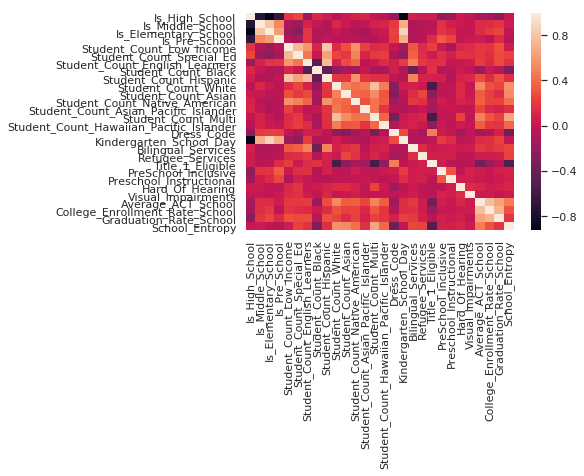

In [308]:
corr = dropped.corr()

# plot the heatmap
heatmap = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
fig = heatmap.get_figure()
fig.savefig('corr_map') 

In [309]:
dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525 entries, 413 to 422
Data columns (total 32 columns):
School_Type                                525 non-null object
Is_High_School                             525 non-null int64
Is_Middle_School                           525 non-null int64
Is_Elementary_School                       525 non-null int64
Is_Pre_School                              525 non-null int64
Student_Count_Low_Income                   525 non-null int64
Student_Count_Special_Ed                   525 non-null int64
Student_Count_English_Learners             525 non-null int64
Student_Count_Black                        525 non-null int64
Student_Count_Hispanic                     525 non-null int64
Student_Count_White                        525 non-null int64
Student_Count_Asian                        525 non-null int64
Student_Count_Native_American              525 non-null int64
Student_Count_Asian_Pacific_Islander       525 non-null int64
Student_Count_Multi     

In [310]:
dropped_dummies = pd.get_dummies(dropped)

In [311]:
drop_lin_reg = ['Is_Pre_School', 'School_Type_Career academy', 'ADA_Accessible_No/unknown accessibility', 
                'PreK_School_Day_0', 'Rating_Status_Not Applicable']

In [312]:
dropped_dummies.drop(drop_lin_reg, axis=1, inplace=True)

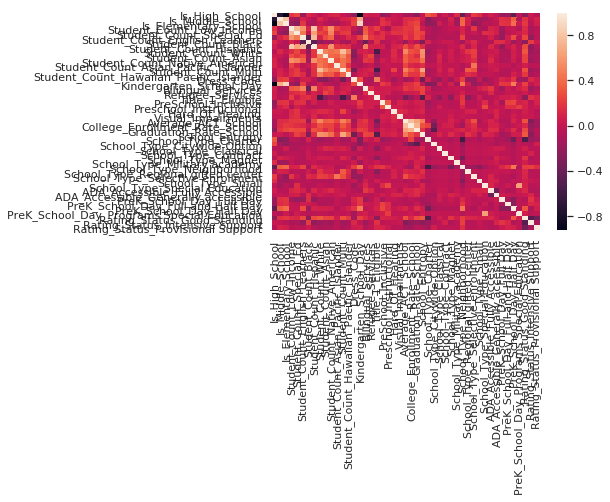

In [313]:
for col in dropped_dummies.columns:
    col = col.replace(' ', '_')
    
corr = dropped_dummies.corr()

# plot the heatmap
heatmap = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
sns.set(rc={'figure.figsize':(14,14)})
fig = heatmap.get_figure()
fig.savefig('img/corr_map') 

In [314]:
drop_after_map = ['Student_Count_Black', 'Student_Count_Hispanic', 'Student_Count_White', 'Student_Count_Asian', 'Student_Count_Native_American', 'Student_Count_Hawaiian_Pacific_Islander', 'Student_Count_Multi', 'Student_Count_Asian_Pacific_Islander']
dropped_dummies.drop(drop_after_map, axis=1, inplace=True)

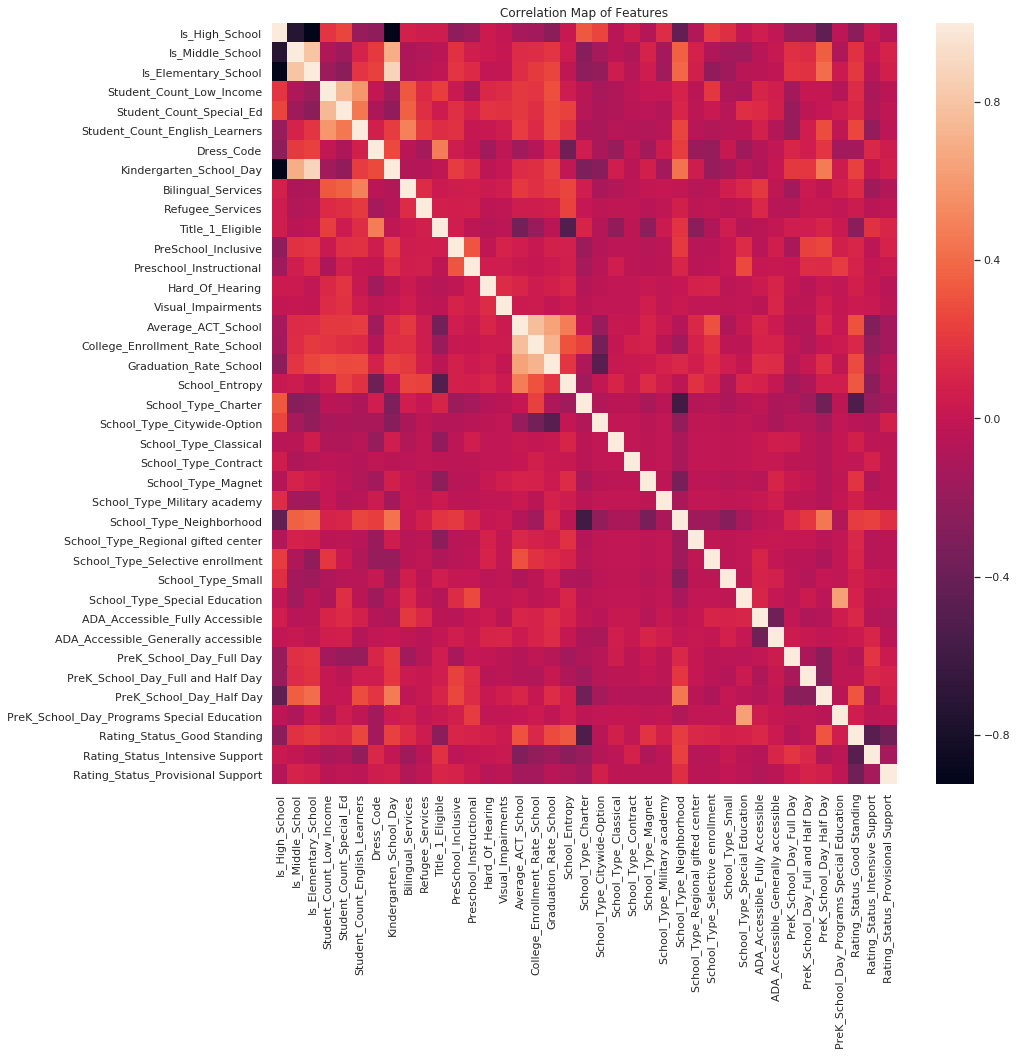

In [315]:
for col in dropped_dummies.columns:
    col.replace(' ', '_')
corr = dropped_dummies.corr()

# plot the heatmap
heatmap = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns).set_title("Correlation Map of Features")
sns.set(rc={'figure.figsize':(14,14)})
fig = heatmap.get_figure()
fig.savefig('img/corr_map') 

In [320]:
y_train = dropped_dummies.pop('School_Entropy')

In [321]:
X_train = dropped_dummies
X_scaled = preprocessing.scale(X_train)

/home/neha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  


In [322]:
# X_scaled = sm.add_constant(X_train, has_constant='add')

In [323]:
X_scaled = sm.add_constant(X_train, has_constant='add')
model = sm.OLS(y_train, X_scaled).fit() 
predictions = model.predict(X_scaled)
model.summary()

/home/neha/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         School_Entropy   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     17.11
Date:                Tue, 07 May 2019   Prob (F-statistic):           2.94e-67
Time:                        19:05:58   Log-Likelihood:                -73.741
No. Observations:                 525   AIC:                             225.5
Df Residuals:                     486   BIC:                             391.8
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          0.1160      0.316      0.368      0.713      -0.504       0.736
Is_High_School                                 0.2237      0.099      2.251      0.025       0.028       0.419
Is_Middle_School                               0.1535      0.051      3.007      0.003       0.053       0.254
Is_Elementary_School                          -0.0895      0.100     -0.891      0.373      -0.287       0.108
Student_Count_Low_Income                      -0.0004   8.81e-05     -4.166      0.000      -0.001      -0.000
Student_Count_Special_Ed                       0.0017      0.001      3.335      0.001       0.001       0.003
Student_Count_English_Learners                 0.0004      0.000      2.373      0.018     6.7e-05       0.001
Dress_Code                                    -0.0771      0.046     -1.664      0.097      -0.168       0.014
Kindergarten_School_Day                        0.0866      0.079      1.092      0.275      -0.069       0.242
Bilingual_Services                             0.1236      0.032      3.828      0.000       0.060       0.187
Refugee_Services                               0.5134      0.079      6.520      0.000       0.359       0.668
Title_1_Eligible                              -0.3475      0.054     -6.393      0.000      -0.454      -0.241
PreSchool_Inclusive                            0.0350      0.045      0.785      0.433      -0.053       0.122
Preschool_Instructional                       -0.0216      0.054     -0.403      0.687      -0.127       0.084
Hard_Of_Hearing                                0.1158      0.096      1.206      0.229      -0.073       0.304
Visual_Impairments                            -0.1207      0.152     -0.792      0.429      -0.420       0.179
Average_ACT_School                             0.0384      0.011      3.459      0.001       0.017       0.060
College_Enrollment_Rate_School                 0.0074      0.002      4.044      0.000       0.004       0.011
Graduation_Rate_School                        -0.0055      0.001     -4.386      0.000      -0.008      -0.003
School_Type_Charter                           -0.3863      0.268     -1.443      0.150      -0.912       0.140
School_Type_Citywide-Option                   -0.0484      0.245     -0.198      0.843      -0.529       0.432
School_Type_Classical                          0.4342      0.269      1.613      0.107      -0.095       0.963
School_Type_Contract                           0.2496      0.262      0.954      0.341      -0.265       0.764
School_Type_Magnet                             0.2374      0.223      1.063      0.288      -0.201       0.676
School_Type_Military academy                   0.6056      0.264      2.290      0.022

In [273]:
# model.summary()

In [45]:
X_scaled = X_scaled.iloc[:, 1:]
lasso = Lasso()
alphas = np.logspace(-4, 10, 30)
parameters = {'alpha': alphas}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_scaled, y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

/home/neha/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/neha/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/neha/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/neha/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. 

{'alpha': 0.0028072162039411755}
-0.07110430968241901


(0.0001, 10000000000.0)

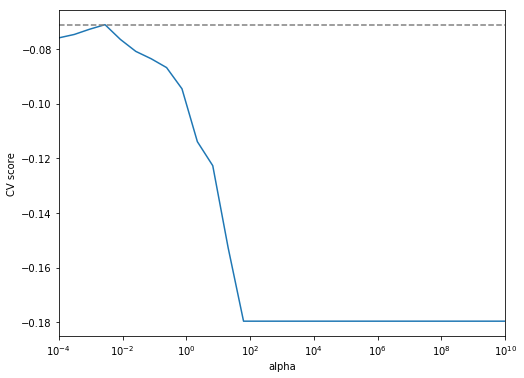

In [46]:
scores = lasso_regressor.cv_results_['mean_test_score']
scores_std = lasso_regressor.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(5)

# plt.semilogx(alphas, scores + std_error, 'b--')
# plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
# plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])


In [47]:
reg = Lasso(alpha=.0028)
reg.fit(X_scaled, y_train) 
print(reg.coef_)
reg.intercept_ 


[ 4.74116858e-02  0.00000000e+00 -0.00000000e+00  3.37142965e-04
  1.93758865e-03  2.25343598e-04 -9.50787968e-04 -8.98923543e-04
 -5.19149356e-04  3.95910975e-04  3.05511211e-02  0.00000000e+00
  1.46719808e-02  2.48253624e-03 -7.25681889e-02 -0.00000000e+00
  6.49887524e-02  1.46309757e-01 -1.91095330e-01  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  4.22538227e-02
  1.18206826e-04 -1.19195634e-04 -1.13563471e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.10089735e-02  1.74147057e-03
 -1.50043474e-02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.62739612e-02
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.93147357e-02  0.00000000e+00]


-0.007209284380126246

In [48]:
len(reg.coef_)

46

In [49]:
len(X_scaled.columns)

46

In [51]:
for tup in zip(X_scaled.columns, reg.coef_):
    print(tup)

('Is_High_School', 0.04741168584306294)
('Is_Middle_School', 0.0)
('Is_Elementary_School', -0.0)
('Student_Count_Low_Income', 0.00033714296524330094)
('Student_Count_Special_Ed', 0.0019375886463730526)
('Student_Count_English_Learners', 0.00022534359804570622)
('Student_Count_Black', -0.000950787967583961)
('Student_Count_Hispanic', -0.0008989235433590137)
('Student_Count_White', -0.0005191493559210791)
('Student_Count_Asian', 0.0003959109750887457)
('Student_Count_Native_American', 0.030551121079055752)
('Student_Count_Asian_Pacific_Islander', 0.0)
('Student_Count_Multi', 0.014671980771538518)
('Student_Count_Hawaiian_Pacific_Islander', 0.002482536238483663)
('Dress_Code', -0.07256818886351932)
('Kindergarten_School_Day', -0.0)
('Bilingual_Services', 0.06498875237142787)
('Refugee_Services', 0.14630975677819483)
('Title_1_Eligible', -0.19109532970648999)
('PreSchool_Inclusive', 0.0)
('Preschool_Instructional', -0.0)
('Hard_Of_Hearing', -0.0)
('Visual_Impairments', -0.0)
('Average_ACT_

In [54]:
lasso_drop = ['Is_Middle_School',
'Is_Elementary_School',
'Kindergarten_School_Day',
'PreSchool_Inclusive',
'Preschool_Instructional',
'Hard_Of_Hearing', 
'Visual_Impairments', 
'School_Type_Citywide-Option', 
'School_Type_Classical', 
'School_Type_Contract', 
'School_Type_Regional gifted center', 
'School_Type_Selective enrollment', 
'School_Type_Small', 
'School_Type_Special Education', 
'ADA_Accessible_Fully Accessible', 
'ADA_Accessible_Generally accessible',
'PreK_School_Day_Full and Half Day', 
'PreK_School_Day_Half Day', 
'PreK_School_Day_Programs Special Education', 
'Rating_Status_Provisional Support']


In [55]:
new_X_scaled = X_scaled.drop(lasso_drop, axis=1)

In [57]:
new_X_scaled = sm.add_constant(new_X_scaled, has_constant='add')
model = sm.OLS(y_train, new_X_scaled).fit() 
predictions = model.predict(new_X_scaled)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         School_Entropy   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     39.21
Date:                Tue, 02 Apr 2019   Prob (F-statistic):          6.86e-103
Time:                        00:00:50   Log-Likelihood:                 1.1977
No. Observations:                 523   AIC:                             51.60
Df Residuals:                     496   BIC:                             166.6
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.0551      0.131      0.419      0.676      -0.203       0.313
Is_High_School                              0.0514      0.037      1.384      0.167      -0.022       0.124
Student_Count_Low_Income                    0.0004      0.000      1.297      0.195      -0.000       0.001
Student_Count_Special_Ed                    0.0020      0.000      5.160      0.000       0.001       0.003
Student_Count_English_Learners              0.0003      0.000      1.614      0.107      -6e-05       0.001
Student_Count_Black                        -0.0009      0.000     -3.933      0.000      -0.001      -0.000
Student_Count_Hispanic                     -0.0009      0.000     -3.734      0.000      -0.001      -0.000
Student_Count_White                        -0.0005      0.000     -3.325      0.001      -0.001      -0.000
Student_Count_Asian                         0.0003      0.000      0.828      0.408      -0.000       0.001
Student_Count_Native_American               0.0297      0.006      5.037      0.000       0.018       0.041
Student_Count_Asian_Pacific_Islander        0.1987      0.153      1.301      0.194      -0.101       0.499
Student_Count_Multi                         0.0136      0.002      7.473      0.000       0.010       0.017
Student_Count_Hawaiian_Pacific_Islander     0.0036      0.006      0.597      0.551      -0.008       0.015
Dress_Code                                 -0.0762      0.037     -2.069      0.039      -0.149      -0.004
Bilingual_Services                          0.0904      0.027      3.353      0.001       0.037       0.143
Refugee_Services                            0.2584      0.068      3.823      0.000       0.126       0.391
Title_1_Eligible                           -0.2348      0.050     -4.695      0.000      -0.333      -0.137
Average_ACT_School                          0.0403      0.008      4.773      0.000       0.024       0.057
College_Enrollment_Rate_School              0.0023      0.002      1.268      0.205      -0.001       0.006
Graduation_Rate_School                     -0.0014      0.001     -1.151      0.250      -0.004       0.001
School_Type_Charter                        -0.1913      0.056     -3.393      0.001      -0.302      -0.080
School_Type_Magnet                          0.1544      0.056      2.777      0.006       0.045       0.264
School_Type_Military academy                0.3468      0.124      2.801      0.005       0.104       0.590
School_Type_Neighborhood                   -0.0052      0.039     -0.132      0.895      -0.082       0.072
PreK_School_Day_Full Day                   -0.0662      0.040     -1.671      0.095      -0.144       0.012
Rating_Status_Good Standing                -0.0352      0.0

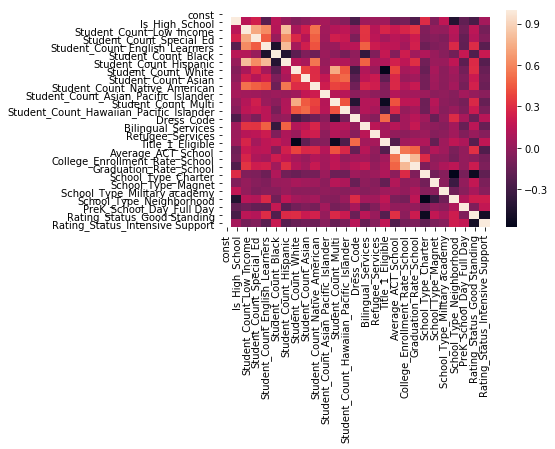

In [58]:
corr = new_X_scaled.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)